<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Topological Quantum Walks on IBM Q*_

This notebook is based on the paper of Radhakrishnan Balu, Daniel Castillo, and George Siopsis, "Physical realization of topological quantum walks on IBM-Q and beyond" arXiv:1710.03615 \[quant-ph\](2017).

### Contributors
Keita Takeuchi (Univ. of Tokyo) and Rudy Raymond (IBM Research - Tokyo)
***

## Introduction: challenges in implementing topological walk
In this section, we introduce one model of quantum walk called *split-step topological quantum walk*.

We define Hilbert space of quantum walker states and coin states as 
$\mathcal{H}_{\mathcal{w}}=\{\vert x \rangle, x\in\mathbb{Z}_N\}, \mathcal{H}_{\mathcal{c}}=\{\vert 0 \rangle, \vert 1 \rangle\}$, respectively. Then, step operator is defined as

$$
S^+ := \vert 0 \rangle_c \langle 0 \vert \otimes L^+ + \vert 1 \rangle_c \langle 1 \vert \otimes \mathbb{I}\\
S^- := \vert 0 \rangle_c \langle 0 \vert \otimes \mathbb{I} + \vert 1 \rangle_c \langle 1 \vert \otimes L^-,
$$

where

$$
L^{\pm}\vert x \rangle_{\mathcal w} := \vert (x\pm1)\ \rm{mod}\ N \rangle_{\mathcal w}
$$

is a shift operator. The boundary condition is included.
Also, we define the coin operator as

$$
T(\theta):=e^{-i\theta Y} = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}.
$$

One step of quantum walk is the unitary operator defined as below that uses two mode of coins, i.e., $\theta_1$ and $\theta_2$: 

$$
W := S^- T(\theta_2)S^+ T(\theta_1).
$$

Intuitively speaking, the walk consists of flipping coin states and based on the outcome of the coins, the shifting operator is applied to determine the next position of the walk. 

Next, we consider a walk with two phases that depend on the current position:

$$
(\theta_1,\theta_2) = \begin{cases}
    (\theta_{1}^{-},\ \theta_{2}^{-}) & 0 \leq x < \frac{N}{2} \\
    (\theta_{1}^{+},\ \theta_{2}^{+}) & \frac{N}{2} \leq x < N.
  \end{cases}
$$

Then, two coin operators are rewritten as

$$
\mathcal T_i = \sum^{N-1}_{x=0}e^{-i\theta_i(x) Y_c}\otimes \vert x \rangle_w \langle x \vert,\ i=1,2.
$$

By using this, one step of quantum walk is equal to

$$
W = S^- \mathcal T_2 S^+ \mathcal T_1.
$$

In principle, we can execute the quantum walk by multiplying $W$ many times, but then we need many circuit elements to construct it. This is not possible with the current approximate quantum computers due to large errors produced after each application of circuit elements (gates).

## Hamiltonian of topological walk

Altenatively, we can think of time evolution of the states. The Hamiltonian $H$ is regarded as $H=\lim_{n \to \infty}W^n$(See below for further details.). 

For example, when $(\theta_1,\ \theta_2) = (0,\ \pi/2)$, the Schrödinger equation is

$$
i\frac{d}{dt}\vert \Psi \rangle = H_{\rm I} \vert \Psi \rangle,\ H_{\rm I} = -Y\otimes [2\mathbb I+L^+ + L^-].
$$

If Hamiltonian is time independent, the solution of the Schrödinger equation is

$$
\vert \Psi(t) \rangle = e^{-iHt} \vert \Psi(0) \rangle,
$$

so we can get the final state at arbitrary time $t$ at once without operating W step by step, if we know the corresponding Hamiltonian.

The Hamiltonian can be computed as below.

Set $(\theta_1,\ \theta_2) = (\epsilon,\ \pi/2+\epsilon)$, and $\epsilon\to 0$ and the number of step $s\to \infty$
while $se=t/2$(finite variable). Then,
\begin{align*}
    H_I&=\lim_{n \to \infty}W^n\\
    \rm{(LHS)} &= \mathbb{I}-iH_{I}t+O(t^2)\\
    \rm{(RHS)} &= \lim_{\substack{s\to \infty\\ \epsilon\to 0}}(W^4)^{s/4}=
    \lim_{\substack{s\to \infty\\ \epsilon\to0}}(\mathbb{I}+O(\epsilon))^{s/4}\\
     &\simeq \lim_{\substack{s\to \infty\\ \epsilon\to 0}}\mathbb{I}+\frac{s}{4}O(\epsilon)\\
     &= \lim_{\epsilon\to 0}\mathbb{I}+iY\otimes [2\mathbb I+L^+ + L^-]t+O(\epsilon).
\end{align*}
Therefore,
$$H_{\rm I} = -Y\otimes [2\mathbb I+L^+ + L^-].$$

## Computation model 

In order to check the correctness of results of the implementation of quantum walk by using IBMQ, we investigate two models, which have different features of coin phases. Let the number of positions on the line $n$ is 4.
- $\rm I / \rm II:\ (\theta_1,\theta_2) = \begin{cases}
    (0,\ -\pi/2) & 0 \leq x < 2 \\
    (0,\ \pi/2) & 2 \leq x < 4
  \end{cases}$
- $\rm I:\ (\theta_1,\theta_2)=(0,\ \pi/2),\ 0 \leq x < 4$

That is, the former is a quantum walk on a line with two phases of coins, while the latter is that with only one phase of coins.

<img src="images/q_walk_lattice_2phase.png" width="30%" height="30%">
<div style="text-align: center;">
Figure 1. Quantum Walk on a line with two phases
</div>

The Hamiltonian operators for each of the walk on the line are, respectively, 
$$
H_{\rm I/II} = Y \otimes \mathbb I \otimes \frac{\mathbb I + Z}{2}\\
H_{\rm I} = Y\otimes (2\mathbb I\otimes \mathbb I + \mathbb I\otimes X + X \otimes X).
$$

Then, we want to implement the above Hamiltonian operators with the unitary operators as product of two-qubit gates CNOTs, CZs, and single-qubit gate rotation matrices. Notice that the CNOT and CZ gates are
\begin{align*}
  \rm{CNOT_{ct}}&=\left |0\right\rangle_c\left\langle0\right | \otimes I_t + \left |1\right\rangle_c\left\langle1\right | \otimes X_t\\
  \rm{CZ_{ct}}&=\left |0\right\rangle_c\left\langle0\right | \otimes I_t + \left |1\right\rangle_c\left\langle1\right | \otimes Z_t.
\end{align*}

Below is the reference of converting Hamiltonian into unitary operators useful for the topological quantum walk.
<br><br>


<div style="text-align: center;">
Table 1. Relation between the unitary operator and product of elementary gates
</div>

|unitary operator|product of circuit elements|
|:-:|:-:|
|$e^{-i\theta X_c X_j}$|$\rm{CNOT_{cj}}\cdot e^{-i\theta X_c t}\cdot \rm{CNOT_{cj}}$|
|$e^{-i\theta X_c Z_j}$|$\rm{CZ_{cj}}\cdot e^{-i\theta X_c t}\cdot \rm{CZ_{cj}}$|
|$e^{-i\theta Y_c X_j}$|$\rm{CNOT_{cj}}\cdot e^{i\theta Y_c t}\cdot \rm{CNOT_{cj}}$|
|$e^{-i\theta Y_c Z_j}$|$\rm{CNOT_{jc}}\cdot e^{-i\theta Y_c t}\cdot \rm{CNOT_{jc}}$|
|$e^{-i\theta Z_c X_j}$|$\rm{CZ_{cj}}\cdot e^{-i\theta X_j t}\cdot \rm{CZ_{cj}}$|
|$e^{-i\theta Z_c Z_j}$|$\rm{CNOT_{jc}}\cdot e^{-i\theta Z_c t}\cdot \rm{CNOT_{jc}}$|

By using these formula, the unitary operators are represented by only CNOT, CZ, and rotation matrices, so we can implement them by using IBM Q, as below.

### Phase I/II:<br><br>

\begin{align*}
  e^{-iH_{I/II}t}=~&e^{-itY_c \otimes \mathbb I_0 \otimes \frac{\mathbb I_1 + Z_1}{2}}\\
  =~& e^{-iY_c t}e^{-itY_c\otimes Z_1}\\
  =~& e^{-iY_c t}\cdot\rm{CNOT_{1c}}\cdot e^{-i Y_c t}\cdot\rm{CNOT_{1c}}
\end{align*}

<img src="images/c12.png" width="50%" height="60%">
<div style="text-align: center;">
Figure 2. Phase I/II on $N=4$ lattice$(t=8)$ - $q[0]:2^0,\ q[1]:coin,\ q[2]:2^1$
</div>

<br><br>
### Phase I:<br><br>

\begin{align*}
  e^{-iH_I t}=~&e^{-itY_c\otimes (2\mathbb I_0\otimes \mathbb I_1 + \mathbb I_0\otimes X_1 + X_0 \otimes X_1)}\\
  =~&e^{-2itY_c}e^{-itY_c\otimes X_1}e^{-itY_c\otimes X_0 \otimes X_1}\\
  =~&e^{-2iY_c t}\cdot\rm{CNOT_{c1}}\cdot\rm{CNOT_{c0}}\cdot e^{-iY_c t}\cdot\rm{CNOT_{c0}}\cdot e^{-iY_c t}\cdot\rm{CNOT_{c1}}
\end{align*}

<img src="images/c1.png" width="70%" height="70%">
<div style="text-align: center;">
Figure 3. Phase I on $N=4$ lattice$(t=8)$ - $q[0]:2^0,\ q[1]:2^1,\ q[2]:coin$
</div>

## Implementation

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing the QISKit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute, IBMQ, Aer
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [12]:
#import Qconfig and set APIToken and API url
try:
    import sys
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
except Exception as e:
    print(e)
IBMQ.enable_account(qx_config['APItoken'], qx_config['url'])

In [3]:
#for plot with 16qubit
from functools import reduce
from scipy import linalg as la
from collections import Counter

def plot_histogram5(data, number_to_keep=False):
    """Plot a histogram of data.
    data is a dictionary of  {'000': 5, '010': 113, ...}
    number_to_keep is the number of terms to plot and rest is made into a
    single bar called other values
    """
    if number_to_keep is not False:
        data_temp = dict(Counter(data).most_common(number_to_keep))
        data_temp["rest"] = sum(data.values()) - sum(data_temp.values())
        data = data_temp

    labels = sorted(data)
    values = np.array([data[key] for key in labels], dtype=float)
    pvalues = values / sum(values)
    numelem = len(values)
    ind = np.arange(numelem)  # the x locations for the groups
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots()
    rects = ax.bar(ind, pvalues, width, color='seagreen')
    # add some text for labels, title, and axes ticks
    ax.set_ylabel('Probabilities', fontsize=12)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, fontsize=12, rotation=70)
    ax.set_ylim([0., min([1.2, max([1.2 * val for val in pvalues])])])
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
                '%f' % float(height),
                ha='center', va='bottom', fontsize=8)
    plt.show()

**Quantum walk, phase I/II on $N=4$ lattice$(t=8)$**

In [4]:
q1_2 = QuantumRegister(3)
c1_2 = ClassicalRegister(3)
qw1_2 = QuantumCircuit(q1_2, c1_2)

In [6]:
t=8 #time
qw1_2.x(q1_2[2])
qw1_2.u3(t, 0, 0, q1_2[1])
qw1_2.cx(q1_2[2], q1_2[1])
qw1_2.u3(t, 0, 0, q1_2[1])
qw1_2.cx(q1_2[2], q1_2[1])
qw1_2.measure(q1_2[0], c1_2[0])
qw1_2.measure(q1_2[1], c1_2[2])
qw1_2.measure(q1_2[2], c1_2[1])
print(qw1_2.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q1[3];
creg c1[3];
x q1[2];
u3(8,0,0) q1[1];
cx q1[2],q1[1];
u3(8,0,0) q1[1];
cx q1[2],q1[1];
measure q1[0] -> c1[0];
measure q1[1] -> c1[2];
measure q1[2] -> c1[1];



Below is the result when executing the circuit on the simulator.

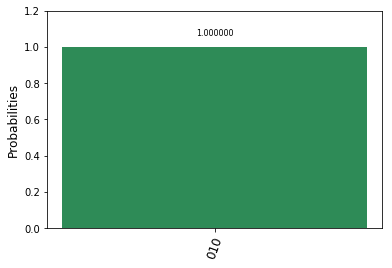

In [9]:
result = execute(qw1_2, Aer.get_backend('qasm_simulator'), shots=1000)
plot_histogram5(result.result().get_counts(qw1_2))

And below is the result when executing the circuit on the real device.

In [15]:
IBMQ.backends(operational=True, simulator=False)

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>]

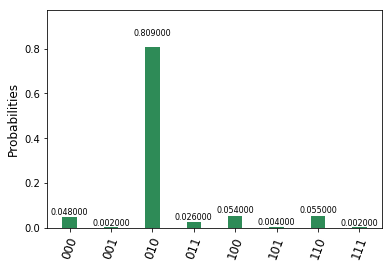

In [16]:
result = execute(qw1_2, IBMQ.get_backend('ibmqx4'), shots=1000)
plot_histogram5(result.result().get_counts(qw1_2))

**Conclusion**: The walker is bounded at the initial state, which is the boundary of two phases, when the quantum walk on the line has two phases. 

**Quantum walk, phase I on $N=4$ lattice$(t=8)$**

In [17]:
q1 = QuantumRegister(3)
c1 = ClassicalRegister(3)
qw1 = QuantumCircuit(q1, c1)

In [18]:
t=8 #time
qw1.x(q1[1])
qw1.cx(q1[2], q1[1])
qw1.u3(t, 0, 0, q1[2])
qw1.cx(q1[2], q1[0])
qw1.u3(t, 0, 0, q1[2])
qw1.cx(q1[2], q1[0])
qw1.cx(q1[2], q1[1])
qw1.u3(2*t, 0, 0, q1[2])
qw1.measure(q1[0], c1[0])
qw1.measure(q1[1], c1[1])
qw1.measure(q1[2], c1[2])
print(qw1.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q2[3];
creg c2[3];
x q2[1];
cx q2[2],q2[1];
u3(8,0,0) q2[2];
cx q2[2],q2[0];
u3(8,0,0) q2[2];
cx q2[2],q2[0];
cx q2[2],q2[1];
u3(16,0,0) q2[2];
measure q2[0] -> c2[0];
measure q2[1] -> c2[1];
measure q2[2] -> c2[2];



Below is the result when executing the circuit on the simulator.

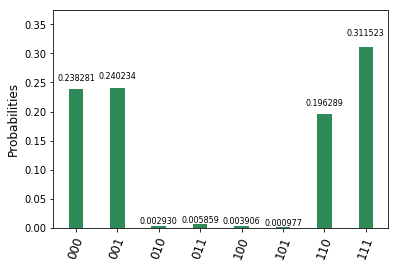

In [19]:
result = execute(qw1, Aer.get_backend('qasm_simulator'))
plot_histogram5(result.result().get_counts(qw1))

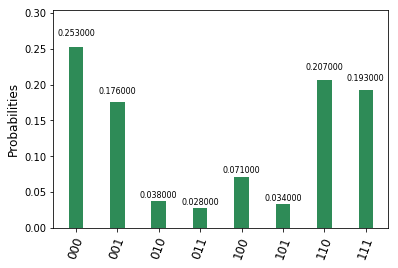

In [20]:
result = execute(qw1, IBMQ.get_backend('ibmqx4'), shots=1000)
plot_histogram5(result.result().get_counts(qw1))

**Conclusion**: The walker is unbounded when the quantum walk on the line has one phase.

We can see that the results from simulators match those from real devices. This hints that IBM Q systems can be used to experiments with topological quantum walk.